
# Name : **Shravanthi Balasubramanian**
# School :SCDS
# Email ID : *shravanthi.b-26@scds.saiuniversity.edu.in

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Car_Dataset.zip'
extract_path = '/content/Car_Dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: /content/Car_Dataset


In [ ]:
import shutil
source_dir = '/content/Car_Dataset/Car_Dataset'
train_dir = '/content/splits/train'
test_dir = '/content/splits/test'

if os.path.exists(source_dir):
    print("Source directory exists:", os.listdir(source_dir))
else:
    print("Source directory does not exist:", source_dir)

print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        all_files = os.listdir(class_path)

        train_files, test_files = train_test_split(all_files, test_size=0.25, random_state=42)

        for file in train_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(train_dir, class_name, file)
            if not os.path.exists(dst):
                shutil.move(src, dst)

        for file in test_files:
            src = os.path.join(class_path, file)
            dst = os.path.join(test_dir, class_name, file)
            if not os.path.exists(dst):
                shutil.move(src, dst)

Source directory exists: ['Rolls Royce', 'Hyundai Creta', 'Tata Safari', 'Mahindra Scorpio', 'Swift', 'Toyota Innova', 'Audi']
Train directory exists: False
Test directory exists: False


In [ ]:
def prepare_data(source_dir):
    file_paths, labels = [], []
    classes = os.listdir(source_dir)
    for class_name in classes:
        class_folder = os.path.join(source_dir, class_name)
        if os.path.isdir(class_folder):
            for file in os.listdir(class_folder):
                file_paths.append(os.path.join(class_folder, file))
                labels.append(class_name)
    return file_paths, labels, classes

file_paths, labels, classes = prepare_data(source_dir)
num_classes = len(classes)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

#training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

#validation data generator
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

#testing data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode= 'categorical',
    shuffle=False
)

#number of Classes
num_classes = len(train_generator.class_indices)



Found 2811 images belonging to 7 classes.
Found 309 images belonging to 7 classes.
Found 1045 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#number of classes
num_classes = len(train_generator.class_indices)

#load the base DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#train ALL the layers
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.15)(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/DenseNet201_TL.keras',
                             monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[checkpoint, early_stop]
)

model.save('/content/drive/MyDrive/DenseNet201_TL_final.keras')
print("Model training complete. Best model saved.")


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.3561 - loss: 1.7278
Epoch 1: val_accuracy improved from -inf to 0.69256, saving model to /content/drive/MyDrive/DenseNet201_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 115s 790ms/step - accuracy: 0.3578 - loss: 1.7242 - val_accuracy: 0.6926 - val_loss: 0.9119
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7254 - loss: 0.8648
Epoch 2: val_accuracy improved from 0.69256 to 0.86084, saving model to /content/drive/MyDrive/DenseNet201_TL.keras
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.7258 - loss: 0.8639 - val_accuracy: 0.8608 - val_loss: 0.6153
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.8309 - loss: 0.6117
Epoch 3: val_accuracy did not improve from 0.86084
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.8309 - loss: 0.6116 - val_accuracy: 0.8544 - val_loss: 0.5174
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8680 - loss: 0.4930
Epoch 4: val_accuracy improved f

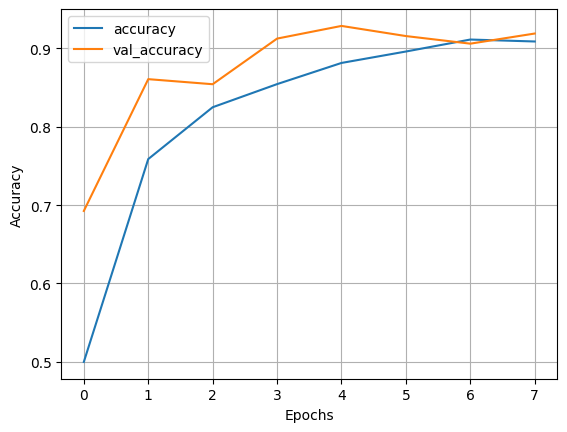

In [ ]:
def plot_history(history):
    metrics = ['accuracy', 'val_accuracy']
    progress = {k: v for k, v in history.history.items() if k in metrics}
    pd.DataFrame(progress).plot()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()

plot_history(history)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 570ms/step


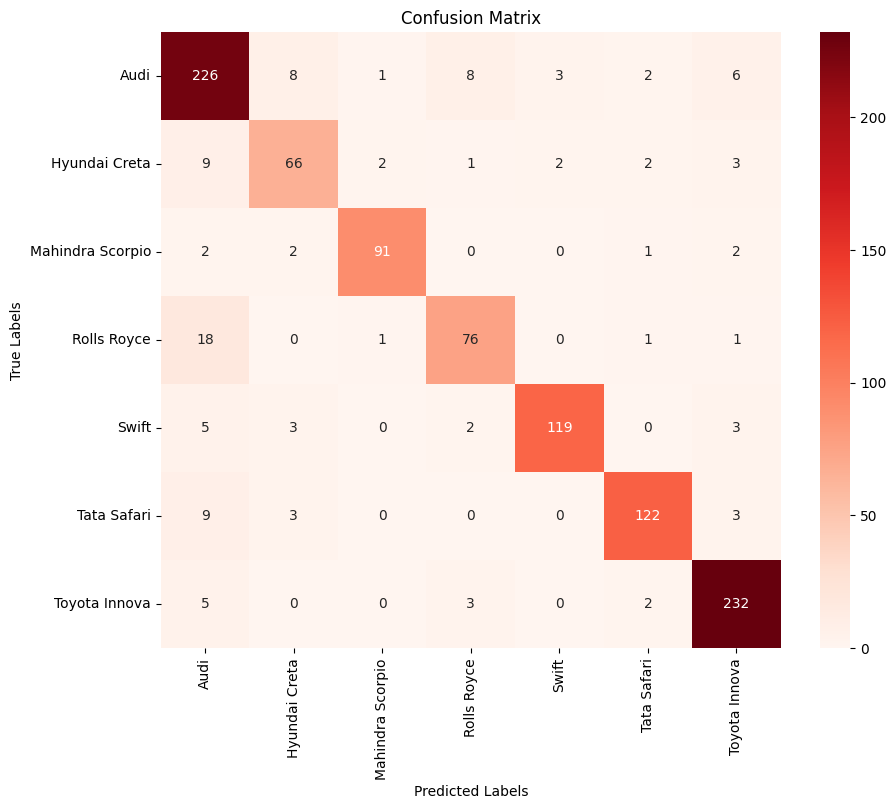

                  precision    recall  f1-score   support

            Audi       0.82      0.89      0.86       254
   Hyundai Creta       0.80      0.78      0.79        85
Mahindra Scorpio       0.96      0.93      0.94        98
     Rolls Royce       0.84      0.78      0.81        97
           Swift       0.96      0.90      0.93       132
     Tata Safari       0.94      0.89      0.91       137
   Toyota Innova       0.93      0.96      0.94       242

        accuracy                           0.89      1045
       macro avg       0.89      0.88      0.88      1045
    weighted avg       0.89      0.89      0.89      1045



In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

model = load_model('/content/drive/MyDrive/DenseNet201_TL_final.keras')

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_mat = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Reds',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print(report)
